# GRU

In [1]:
VOCAB_SIZE = 300    # 사용할 단어 수
SEQ_LEN = 100       # 시퀀스 하나의 최대 길이

### 데이터 준비

In [2]:
# 데이터 로드
from tensorflow.keras.datasets import imdb

(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=VOCAB_SIZE)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# PyTorch Tensor로 변환
import torch

train_input = [torch.tensor(seq, dtype=torch.long) for seq in train_input]
test_input = [torch.tensor(seq, dtype=torch.long) for seq in test_input]

train_target = torch.tensor(train_target, dtype=torch.long)
test_target = torch.tensor(test_target, dtype=torch.long)

print(len(train_input), len(test_input))
print(train_target.shape, test_target.shape)

25000 25000
torch.Size([25000]) torch.Size([25000])


In [4]:
train_input, test_input = train_input[:10000], test_input[:5000]
train_target, test_target = train_target[:10000], test_target[:5000]

In [5]:
train_input[0]

tensor([  1,  14,  22,  16,  43,   2,   2,   2,   2,  65,   2,   2,  66,   2,
          4, 173,  36, 256,   5,  25, 100,  43,   2, 112,  50,   2,   2,   9,
         35,   2, 284,   5, 150,   4, 172, 112, 167,   2,   2,   2,  39,   4,
        172,   2,   2,  17,   2,  38,  13,   2,   4, 192,  50,  16,   6, 147,
          2,  19,  14,  22,   4,   2,   2,   2,   4,  22,  71,  87,  12,  16,
         43,   2,  38,  76,  15,  13,   2,   4,  22,  17,   2,  17,  12,  16,
          2,  18,   2,   5,  62,   2,  12,   8,   2,   8, 106,   5,   4,   2,
          2,  16,   2,  66,   2,  33,   4, 130,  12,  16,  38,   2,   5,  25,
        124,  51,  36, 135,  48,  25,   2,  33,   6,  22,  12, 215,  28,  77,
         52,   5,  14,   2,  16,  82,   2,   8,   4, 107, 117,   2,  15, 256,
          4,   2,   7,   2,   5,   2,  36,  71,  43,   2,   2,  26,   2,   2,
         46,   7,   4,   2,   2,  13, 104,  88,   4,   2,  15, 297,  98,  32,
          2,  56,  26, 141,   6, 194,   2,  18,   4, 226,  22,  

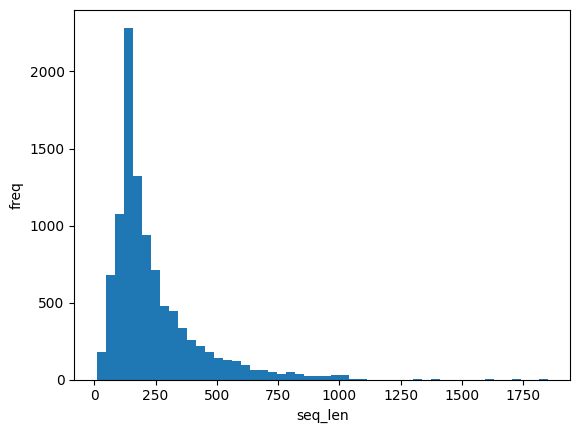

In [6]:
# 입력 데이터 길이 체크
import matplotlib.pyplot as plt
import numpy as np

train_len = [len(seq) for seq in train_input]

plt.hist(train_len, bins=50)
plt.xlabel('seq_len')
plt.ylabel('freq')
plt.show()

In [7]:
# padding 처리
import torch.nn.functional as F

def pad_sequences(sequences, maxlen, padding_value=0):
  padded_sequences = [F.pad(seq[:maxlen], (0, max(0, maxlen-len(seq))), value=padding_value) for seq in sequences]
  return torch.stack(padded_sequences)

train_seq = pad_sequences(train_input, maxlen=SEQ_LEN)
test_seq = pad_sequences(test_input, maxlen=SEQ_LEN)

train_seq.shape, test_seq.shape

(torch.Size([10000, 100]), torch.Size([5000, 100]))

In [8]:
# one-hot encoding
train_onehot = F.one_hot(train_seq, num_classes=VOCAB_SIZE).float()
test_onehot = F.one_hot(test_seq, num_classes=VOCAB_SIZE).float()

train_onehot.shape, test_onehot.shape

(torch.Size([10000, 100, 300]), torch.Size([5000, 100, 300]))

### 모델 준비 및 학습

In [15]:
import torch
import torch.nn as nn

class GRUModel(nn.Module):
  def __init__(self, input_dim, hidden_units, output_dim, return_sequences=False, return_state=False):
    super(GRUModel, self).__init__()
    self.return_sequences = return_sequences
    self.return_state = return_state
    self.gru = nn.GRU(input_size=input_dim, hidden_size=hidden_units, batch_first=True)
    self.fc = nn.Linear(hidden_units, output_dim)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    output, hidden = self.gru(x)
    result_output = self.fc(hidden[-1])

    if self.return_sequences and self.return_state:
      return output, hidden[-1]
    elif self.return_sequences:
      return output
    elif self.return_state:
      return output[:, -1, :], hidden[-1]

    return self.sigmoid(result_output)

In [16]:
HIDDEN_DIM = 8
OUTPUT_DIM = 1

gru_model = GRUModel(input_dim=VOCAB_SIZE, hidden_units=HIDDEN_DIM, output_dim=OUTPUT_DIM)

Epoch 1/100 | Train Loss: 0.6937, Train Acc: 0.5202, Val Loss: 0.6906, Val Acc: 0.5270
Epoch 2/100 | Train Loss: 0.6844, Train Acc: 0.5619, Val Loss: 0.6869, Val Acc: 0.5480
Epoch 3/100 | Train Loss: 0.6595, Train Acc: 0.6056, Val Loss: 0.6429, Val Acc: 0.6570
Epoch 4/100 | Train Loss: 0.6557, Train Acc: 0.6179, Val Loss: 0.6480, Val Acc: 0.6460
Epoch 5/100 | Train Loss: 0.6075, Train Acc: 0.6799, Val Loss: 0.6286, Val Acc: 0.6625
Epoch 6/100 | Train Loss: 0.5852, Train Acc: 0.6995, Val Loss: 0.6125, Val Acc: 0.6690
Epoch 7/100 | Train Loss: 0.5630, Train Acc: 0.7184, Val Loss: 0.5989, Val Acc: 0.6815
Epoch 8/100 | Train Loss: 0.5397, Train Acc: 0.7315, Val Loss: 0.5777, Val Acc: 0.7080
Epoch 9/100 | Train Loss: 0.5230, Train Acc: 0.7420, Val Loss: 0.5639, Val Acc: 0.7115
Epoch 10/100 | Train Loss: 0.5110, Train Acc: 0.7481, Val Loss: 0.5583, Val Acc: 0.7235
Epoch 11/100 | Train Loss: 0.4935, Train Acc: 0.7612, Val Loss: 0.5634, Val Acc: 0.7165
Epoch 12/100 | Train Loss: 0.4870, Train 

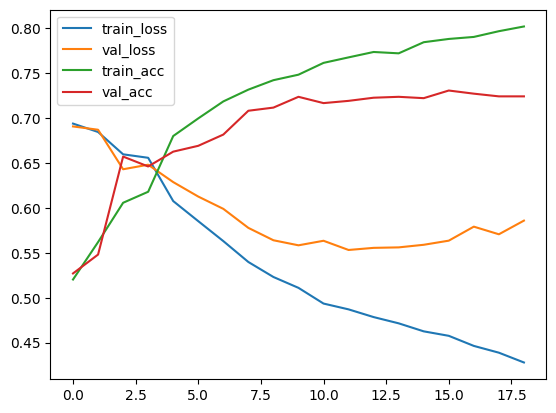

In [17]:
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset, random_split

# 배치 사이즈 설정 + 학습/검증셋 크기 설정
BATCH_SIZE = 65
train_size = int(len(train_onehot) * 0.8)
val_size = len(train_onehot) - train_size

# label 데이터 실수 처리
train_target = train_target.float()
test_target = test_target.float()

# 학습/검증셋 분할 + 미니배치로 사용하도록 DataLoader 생성
train_dataset, val_dataset = random_split(TensorDataset(train_onehot, train_target), [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# epoch, 손실함수, 최적화함수 정의
epochs = 100
criterion = nn.BCELoss()
optimizer = optim.Adam(gru_model.parameters(), lr=0.005)

# 시각화를 위한 손실값/정확도 저장용
train_losses, val_losses, train_accs, val_accs = [], [], [], []

# 조기종료 관련 변수 초기화
early_stopping_patience = 7
best_val_loss = float('inf')
early_stop_counter = 0

# 학습 과정
for epoch in range(epochs):
  # train mode
  gru_model.train()
  total_loss, correct, total = 0, 0, 0

  for inputs, targets in train_loader:
    optimizer.zero_grad()              # 가중치 초기화
    outputs = gru_model(inputs).squeeze()  # 순전파

    loss = criterion(outputs, targets) # 손실 계산

    loss.backward()                    # 역전파
    optimizer.step()                   # 가중치 업데이트
    total_loss += loss.item()

    pred = (outputs > 0.5).float()
    correct += (pred == targets).sum().item()
    total += targets.size(0)

  train_loss = total_loss / len(train_loader)
  train_acc = correct / total
  train_losses.append(train_loss)
  train_accs.append(train_acc)

  # validation mode
  gru_model.eval()
  val_loss, val_correct, val_total = 0, 0, 0

  with torch.no_grad():
    for val_inputs, val_targets in val_loader:
      val_outputs = gru_model(val_inputs).squeeze()
      loss = criterion(val_outputs, val_targets)
      val_loss += loss.item()

      val_pred = (val_outputs > 0.5).float()
      val_correct += (val_pred == val_targets).sum().item()
      val_total += val_targets.size(0)

  val_loss = val_loss / len(val_loader)
  val_acc = val_correct / val_total
  val_losses.append(val_loss)
  val_accs.append(val_acc)

  print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

  # 조기종료 처리
  if val_loss < best_val_loss:
    best_val_loss = val_loss
    early_stop_counter = 0
  else:
    early_stop_counter += 1
    if early_stop_counter >= early_stopping_patience:
      print("Early stopping 할게!")
      break

# 시각화
train_history_df = pd.DataFrame({
    "train_loss": train_losses,
    "val_loss": val_losses,
    "train_acc": train_accs,
    "val_acc": val_accs
})
train_history_df.plot()
plt.show()